We want to use (train) a Gaussian Process for regression analysis so that we can determin (by fitting) 

In [1]:
using CSV
using DataFrames
using PyPlot
# using StatsBase
using Statistics


using ScikitLearn # machine learning package
using ScikitLearn.CrossValidation: train_test_split
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

@sk_import inspection : permutation_importance
# @sk_import metrics : confusion_matrix

PyObject <function permutation_importance at 0x7f4914aeb8c8>

In [2]:
filename = joinpath(pwd(), "descriptors/cof_descriptors.csv")
descriptors = CSV.read(filename, DataFrame)
rename!(descriptors, "crystal_name" => "xtal")

# for some reason these ones aren't working... LOOk INTO IT
skip_for_now = ["07012N3_ddec.cif", "14040N2_ddec.cif", "16290N3_ddec.cif", "21111N3_ddec.cif"]


[delete!(descriptors, findfirst(descriptors[:, "xtal"] .== skip_for_now[i])) for i in 1:length(skip_for_now)]

target_and_cost_data = CSV.read(joinpath(pwd(), "target_and_cost_data.csv"), DataFrame)

target_and_cost_data[1:5, :]

,xtal,henry_coeff,err_henry_coeff
,String,String,String
1,05000N2_ddec.cif,"[1.80109037955602, 1.651416583855947]","[1.80109037955602, 1.651416583855947]"
2,05001N2_ddec.cif,"[5.615571200847626, 5.291361399491628]","[5.615571200847626, 5.291361399491628]"
3,07000N2_ddec.cif,"[4.406490850448608, 4.244245433807373]","[4.406490850448608, 4.244245433807373]"
4,07001N2_ddec.cif,"[1.8438791513442994, 1.7389115810394287]","[1.8438791513442994, 1.7389115810394287]"
5,07002N2_ddec.cif,"[3.2536184151967364, 3.2702232837677]","[3.2536184151967364, 3.2702232837677]"


In [3]:
names(target_and_cost_data)

13-element Vector{String}:
 "xtal"
 "henry_coeff"
 "err_henry_coeff"
 "henry_elapsed_time"
 "henry_total_elapsed_time"
 "henry_selectivity"
 "err_henry_selectivity"
 "gcmc_uptake"
 "err_gcmc_uptake"
 "gcmc_pressure"
 "gcmc_elapsed_time"
 "gcmc_selectivity"
 "err_gcmc_selectivity"

Scikitlearn takes as input:

- a feature matrix X, which must be n_samples by n_features
- a target vector y, which must be n_samples long (of course)

In [4]:
x_cols = [name for name in names(descriptors) if name != "xtal"]
n_xtals = nrow(descriptors)

X = zeros(n_xtals, length(x_cols))
y = zeros(n_xtals)

for (i, row) in enumerate(eachrow(descriptors))
#     @assert descriptors[i, "xtal"] == target_and_cost_data[i, :xtal] 
    
    for (j, col_name) in enumerate(x_cols)
        X[i, j] = row[col_name] / sum(descriptors[:, col_name])
    end
    # need to normalize X by column
    
    y[i] = target_and_cost_data[i, :henry_selectivity] # Xe/Kr Selectivity
end
X # look at y too!

608×14 Matrix{Float64}:
 0.00034169   0.000548847  0.00159703   …  0.0519729   0.0  0.0  0.0
 0.0017514    0.00164654   0.00120742      0.0121386   0.0  0.0  0.0
 0.00232237   0.00219539   0.00130314      0.00762443  0.0  0.0  0.0
 0.000694234  0.00109769   0.000981243     0.0249031   0.0  0.0  0.0
 0.00131792   0.00109769   0.00127962      0.0103599   0.0  0.0  0.0
 0.000828222  0.00192097   0.00201239   …  0.0127898   0.0  0.0  0.0
 0.000883117  0.00192097   0.00208532      0.0111954   0.0  0.0  0.0
 0.00241385   0.00246981   0.001985        0.00280395  0.0  0.0  0.0
 0.000891347  0.00164654   0.00213944      0.00934666  0.0  0.0  0.0
 0.000424645  0.000548847  0.00147073      0.0249875   0.0  0.0  0.0
 0.000667457  0.00109769   0.00137593   …  0.0238828   0.0  0.0  0.0
 0.000872867  0.00137212   0.00131593      0.0236304   0.0  0.0  0.0
 0.00116112   0.00137212   0.00121351      0.0231552   0.0  0.0  0.0
 ⋮                                      ⋱  ⋮                     
 0.000399756 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25);

In [6]:
# train on training data
# kernel = Matern(nu=2.5, length_scale=0.25)
kernel = Matern()
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=true, n_restarts_optimizer=5)

PyObject GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=5, normalize_y=True)

In [7]:
gpr.get_params()

Dict{Any, Any} with 10 entries:
  "normalize_y"                 => true
  "optimizer"                   => "fmin_l_bfgs_b"
  "alpha"                       => 1.0e-10
  "kernel__length_scale_bounds" => (1.0e-5, 100000.0)
  "kernel"                      => PyObject Matern(length_scale=1, nu=1.5)
  "kernel__nu"                  => 1.5
  "random_state"                => nothing
  "kernel__length_scale"        => 1.0
  "n_restarts_optimizer"        => 5
  "copy_X_train"                => true

In [8]:
gpr.fit(X_train, y_train)

PyObject GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=5, normalize_y=True)

In [9]:
gpr.kernel_

PyObject Matern(length_scale=9.91e-05, nu=1.5)

In [10]:
# get predictions on test data
y_pred = gpr.predict(X_test)

152-element Vector{Float64}:
 0.9448821690079318
 0.9449066710832441
 0.9455774892126212
 0.9448808546760127
 0.9448809168783917
 0.9448808546760127
 0.945087501663349
 0.941732780452926
 0.9510770060320758
 0.9448820706368791
 0.9448808569480343
 0.9448808547546631
 0.9446151530758379
 ⋮
 0.9451396013227588
 0.9134412180350263
 0.9448808546583154
 0.9448823368764644
 0.9449004429465645
 0.9468367790793158
 0.9451428402546153
 0.94488085484019
 0.9448808545699271
 0.9448901880675
 0.9448808627492321
 0.9433079082688461

In [11]:
# compute RMSE, R2 on test data
rmse = sqrt(mean((y_test - y_pred).^2))
r2 = gpr.score(X_test, y_test)

-0.024618069362291495

In [12]:
# permutation importance
feature_importances = permutation_importance(gpr, X_test, y_test)

Dict{Any, Any} with 3 entries:
  "importances_std"  => [0.023913, 0.00495643, 0.00652969, 0.00449106, 0.005349…
  "importances_mean" => [-0.0126314, -0.033147, -0.0216386, -0.0231148, -0.0220…
  "importances"      => [-0.0239398 0.034866 … -0.0292053 -0.0244638; -0.036439…

## Parity Plot

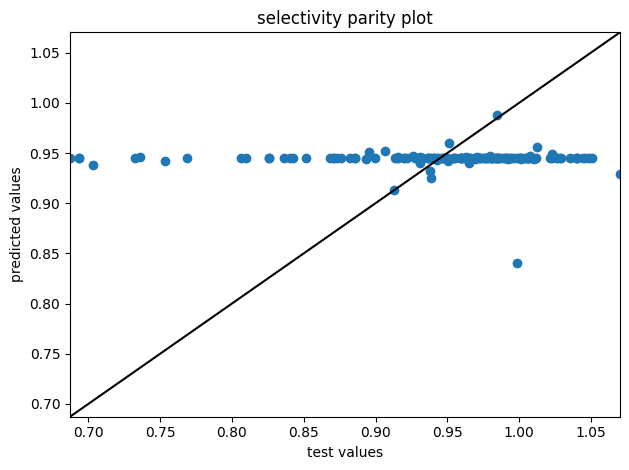

In [13]:
figure()

xmin = minimum(min.(y_test, y_pred))
xmax = maximum(max.(y_test, y_pred))
x = range(xmin, stop=xmax, length=length(y_test))
y = x
plot(x, y, color="k")

scatter(y_test, y_pred)

xlim([xmin, xmax])
ylim([xmin, xmax])

title("selectivity parity plot")
xlabel("test values")
ylabel("predicted values")

tight_layout()